In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as kb
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

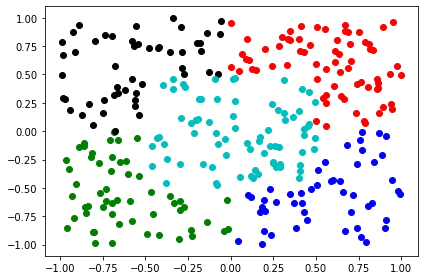

In [13]:
def DataGenerator(center, length, numberOfdata):
    
    fig = plt.figure()
    
    # inputs
    tmp = tf.random.uniform([numberOfdata, 2], maxval = length)
    a = tf.constant([[center[0] - length/2.0, center[1] - length/2.0]])
    b = tf.constant([numberOfdata,1])
    bias = tf.tile(a, b)
    inputs_ = tf.add(tmp, bias)
    # outputs
    outputs_ = np.zeros([numberOfdata])
    
    for idx, elem in enumerate(inputs_):
        if abs(elem[0] - center[0]) < length/4.0 and abs(elem[1] - center[1]) < length/4.0:
            plt.scatter(elem[0], elem[1], c='c')
            outputs_[idx] = 4
        elif elem[0] > center[0] and elem[1] > center[1]:
            plt.scatter(elem[0], elem[1], c='r')
            outputs_[idx] = 0
        elif elem[0] > center[0]:
            plt.scatter(elem[0], elem[1], c='b')
            outputs_[idx] = 1
        elif elem[0] <= center[0] and elem[1] <= center[1]:
            plt.scatter(elem[0], elem[1], c='g')
            outputs_[idx] = 2
        elif elem[0] <= center[0]:
            plt.scatter(elem[0], elem[1], c='k')
            outputs_[idx] = 3
    fig.tight_layout()
    plt.savefig('trainDataset.png')
    plt.show()
    
    return inputs_, outputs_
    
    
    #tmp = tf.fill([numberOfdata, 2], [1,2])
    #print(tmp)

    
centerPoint = [0, 0]
radius = 2
numOfPoint_total = 300

inputs, outputs = DataGenerator(centerPoint, radius, numOfPoint_total)

# take data for its key
buffer = {}

for idx, output_ in enumerate(outputs):
    if output_ in buffer.keys():
        buffer[output_].append(inputs[idx])
    else:
        buffer[output_] = [inputs[idx]]

numOfPoint_min = np.Inf
for i, v in buffer.items():
    if np.less(len(v), numOfPoint_min):
        numOfPoint_min = len(v)
    buffer[i] = np.array(v)
#print(numOfPoint_min)
    
# classify same or dif
inputs = np.empty([1, 2, 2])
outputs = np.empty([1])
ratio_same = 0.5
for key, value in buffer.items():
    for key_, value_ in buffer.items():
        # take same cases
        if key == key_:
            choice1 = np.random.choice(value.shape[0], int(numOfPoint_min * ratio_same), replace=False)
            choosen1 = np.expand_dims(value[choice1], axis=1)
            choice2 = np.random.choice(value_.shape[0], int(numOfPoint_min * ratio_same), replace=False)
            choosen2 = np.expand_dims(value_[choice2], axis=1)   
            
            tmp_same = np.concatenate((choosen1, choosen2), axis=1)
            
            
            inputs = np.concatenate((inputs, tmp_same), axis=0)
            
            outputs = np.concatenate(   (outputs,   np.full(    (int(numOfPoint_min * ratio_same)), 1     )  ), axis=0          )
            
        
        # take different cases
        
        else:
            choice1 = np.random.choice(value.shape[0], int(numOfPoint_min * ratio_same), replace=False)
            choosen1 = np.expand_dims(value[choice1], axis=1)
            choice2 = np.random.choice(value_.shape[0], int(numOfPoint_min * ratio_same), replace=False)
            choosen2 = np.expand_dims(value_[choice2], axis=1)   
            
            tmp_dif = np.concatenate((choosen1, choosen2), axis=1)
            
            
            inputs = np.concatenate((inputs, tmp_dif), axis=0)
            
            outputs = np.concatenate(   (outputs,   np.full(    (int(numOfPoint_min * ratio_same)), 1     )  ), axis=0          )
        

#print(inputs.shape)
#print(outputs.shape)


inputs = np.delete(inputs, 0, axis=0)
outputs = np.delete(outputs, 0, axis=0)

#print(inputs.shape)
#print(outputs.shape)


dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs)).shuffle(inputs.shape[0], reshuffle_each_iteration=True)

dataset_batched = dataset.batch(32, drop_remainder=True)
numberOfData = dataset_batched.cardinality().numpy()
trainDataset = dataset_batched.take(int(numberOfData * 0.7))
validDataset = dataset_batched.skip(int(numberOfData * 0.7))

In [32]:
class MyModel(Model):
    def __init__(self, list_units):
        super(MyModel, self).__init__()
        
        self.layers_custom = self.create_layers(list_units)
        self.lastLayer = Dense(1, activation='sigmoid')
        
    def create_layers(self, list_units):
        layers = []
        for units in list_units:
            layers.append(Dense(units, activation='swish'))
        return layers

    def call(self, x):
        
        x_1 = x[:,0,:]
        x_2 = x[:,1,:]
        #print(x_1.shape)
        x = tf.concat([x_1, x_2], 1)
        
        for layer in self.layers_custom:
            x = layer(x)
        x = self.lastLayer(x)
        
        return x
        
        #x = self.d1(x)
        #return self.d2(x)
    
    


In [43]:
model = MyModel([2])

loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean()
train_acc = tf.keras.metrics.BinaryAccuracy()

valid_loss = tf.keras.metrics.Mean()
valid_acc = tf.keras.metrics.BinaryAccuracy()

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        #print(predictions.shape)
        #print(labels.shape)
        loss = loss_object(labels, predictions)
        train_loss(loss)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_acc.update_state(labels, predictions)
    

@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    valid_loss(t_loss)
    valid_acc.update_state(labels, predictions)
    

EPOCHS = 300

for epoch in range(EPOCHS):
    clear_output(wait=True)
    
    for images, labels in trainDataset:
        train_step(images, tf.expand_dims(labels, axis=-1))
        
    for images, labels in validDataset:
        test_step(images, tf.expand_dims(labels, axis=-1))
        
    template = '에포크: {}, 손실: {:.4f}, 정확도: {:.3f}, 테스트 손실: {:.4f}, 테스트 정확도: {:.3f}'
    print (template.format(epoch+1,
                         train_loss.result(),
                         train_acc.result()*100,
                         valid_loss.result(),
                         valid_acc.result()*100))
    

에포크: 300, 손실: 0.1182, 정확도: 98.692, 테스트 손실: 0.1169, 테스트 정확도: 98.773
